In [17]:
import numpy as np
import matplotlib.pylab as plt
from datetime import datetime, timedelta
from scipy import signal

In [18]:
sample_rate         = 32000     #Hz

M1_amplifier_dB     = 26.       #dB
M3_amplifier_dB     = 32.       #dB
M1_sensitivity_dB   = -165.     #dB re 1V/µPa
M3_sensitivity_dB   = -170.     #dB re 1V/µPa

rho = 1025                      # calculate precise value !
c = 1532                        # calculate precise value !

station             = 'M1'
                            # ( year, month, day, hour, min, sec, microsecond)
start_time          = datetime( 2014,     6,  24,    5,   0,   0 )
end_time            = datetime( 2014,     6,  24,    5,  10,   0 )

freq_band           = [2000, 10000] #Hz

In [19]:
duration = end_time - start_time
files_num = int(np.ceil(duration.seconds / 600))

def file_name(station, start, end):
    return f'{station}_{start.day:02d}{start.month:02d}{start.hour:02d}{start.minute:02d}-{end.day:02d}{end.month:02d}{end.hour:02d}{end.minute:02d}.dat'

current_time = start_time
samples = np.zeros(600 * sample_rate)
data_arrays = []

for i in range(files_num):
    next_time = start_time + timedelta(minutes = 10)
    with open(file_name(station, current_time, next_time), 'r') as fID:
        samples = np.fromfile(fID, np.int16).astype(np.float32)
        data_arrays.append(samples)
    continue_time = next_time

data_array = np.concatenate(data_arrays)
data_array_V = data_array * 0.83 / (2**15)

constant = (M1_sensitivity_dB + M1_amplifier_dB) * (station == 'M1') + (M3_sensitivity_dB + M3_amplifier_dB) * (station == 'M3')

window_size = 256
win = signal.windows.hann(window_size)

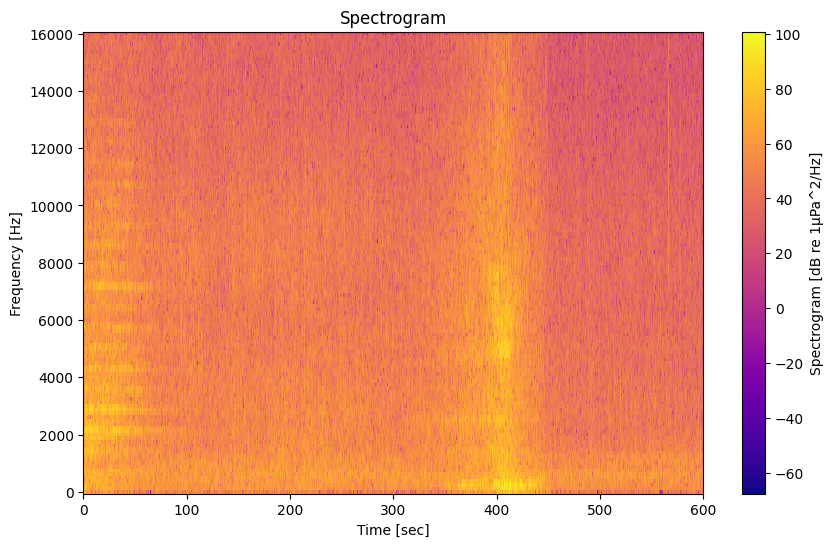

In [20]:
f, t, Zxx = signal.spectrogram(data_array_V[32000*0:32000*60*10], sample_rate, window=win, nperseg=window_size, scaling='density', noverlap=0)

plt.figure(figsize=(10, 6))
plt.pcolormesh(t, f, 10*np.log10(np.abs(Zxx))-constant, cmap = 'plasma')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar(label='Spectrogram [dB re 1μPa^2/Hz]')
plt.title('Spectrogram')
# plt.savefig('Spectrogram1.png')
plt.show()

In [21]:
df = f[1] - f[0]  # frequency resolution
dt = t[1] - t[0]  # time resolution

# Energy calculation
energy_stft = np.sum((np.abs(Zxx[:, 0]))) * df * dt
print(f'STFT Energy: {energy_stft:.6f}')

energy_direct = np.sum(np.abs(data_array_V[0:window_size])**2) / sample_rate
print(f'Direct Energy: {energy_direct:.6f}')

STFT Energy: 0.000027
Direct Energy: 0.000020


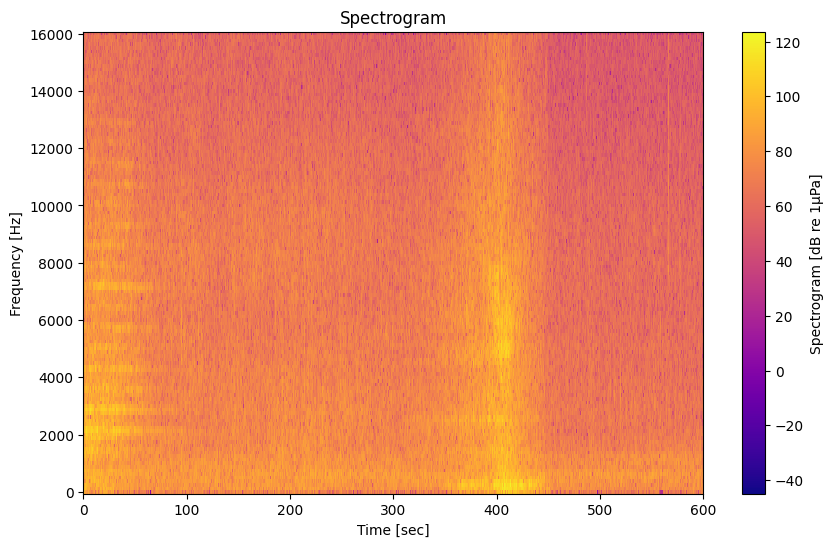

In [22]:
f, t, Zxx = signal.spectrogram(data_array_V[32000*0:32000*60*10], sample_rate, window=win, nperseg=window_size, scaling='spectrum', noverlap=0)

plt.figure(figsize=(10, 6))
plt.pcolormesh(t, f, 10*np.log10(np.abs(Zxx))-constant, cmap = 'plasma')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar(label='Spectrogram [dB re 1μPa]')
plt.title('Spectrogram')
# plt.savefig('Spectrogram2.png')
plt.show()

In [23]:
data_sos = signal.butter(32, freq_band, 'bandpass', fs=sample_rate, output='sos')
# butter(N, Wn, btype='low', analog=False, output='ba', fs=None) second-order sections (‘sos’)
data = signal.sosfiltfilt(data_sos, data_array_V)

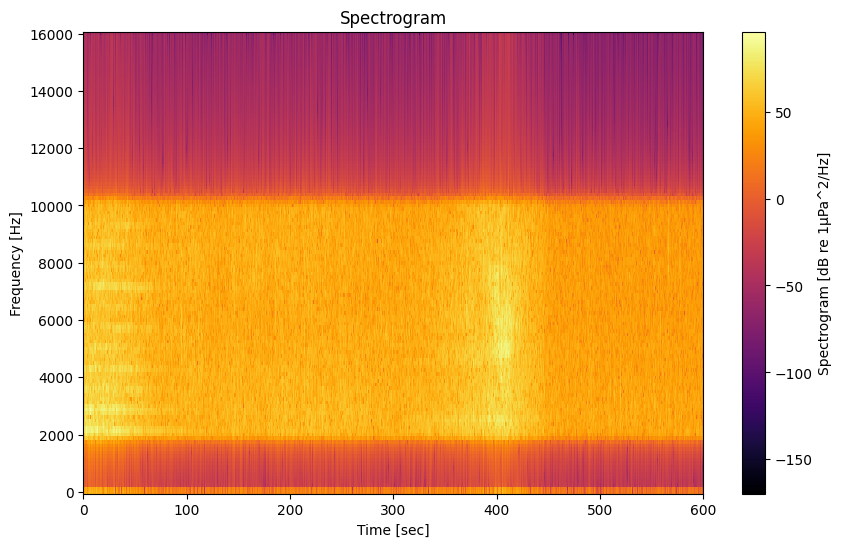

In [24]:
f, t, Zxx = signal.spectrogram(data[32000*0:32000*60*10], sample_rate, window=win, nperseg=window_size, scaling='density', noverlap=0)

plt.figure(figsize=(10, 6))
plt.pcolormesh(t, f, 10*np.log10(np.abs(Zxx))-constant, cmap = 'inferno')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar(label='Spectrogram [dB re 1μPa^2/Hz]')
plt.title('Spectrogram')
# plt.savefig('Spectrogram3.png')
plt.show()

In [25]:
df = f[1] - f[0]  # frequency resolution
dt = t[1] - t[0]  # time resolution

# Energy calculation
energy_stft = np.sum((np.abs(Zxx[:, 0]))) * df * dt
print(f'STFT Energy: {energy_stft:.6f}')

energy_direct = np.sum(np.abs(data_array_V[0:window_size])**2) / sample_rate
print(f'Direct Energy: {energy_direct:.6f}')

STFT Energy: 0.000020
Direct Energy: 0.000020
